In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from random import shuffle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

# Data Exploration

In [2]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [3]:
car_images = glob.glob("vehicles/vehicles/*/*.*")
noncar_images = glob.glob("non-vehicles/non-vehicles/*/*.*")
data_look(car_images, noncar_images)

{'data_type': dtype('float32'),
 'image_shape': (64, 64, 3),
 'n_cars': 8792,
 'n_notcars': 8968}

In [4]:
#Define a function to draw bounding boxes on an image
def draw_bb(image, bboxes, color=(0,0,255), thickness=6):
    #Make a copy of the image
    imcopy=np.copy(image)
    #Iterate through the bounding boxes
    for bbox in bboxes:
        cv.rectangle(imcopy, bbox[0], bbox[1], color, thickness)
    return imcopy

# Histograms of Color

The goal is to write a function that takes an image and computes the RGB color histogram of features given a particular number of bins and pixels intensity range, and returns the concatenated RGB feature vector

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), chist_flag=False):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    if(chist_flag==True):
    # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features
    else:
        return hist_features

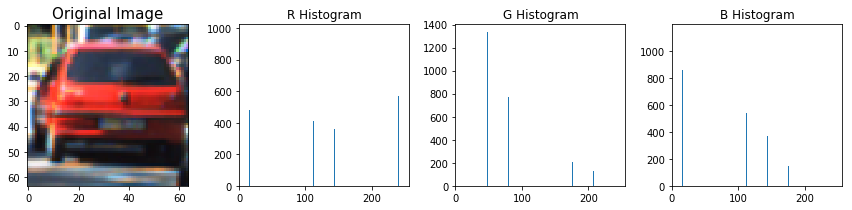

In [6]:
image = cv2.imread('vehicles/vehicles/KITTI_extracted/889.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=8, bins_range=(0, 256), chist_flag=True)
# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Original Image', fontsize=15)
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

# Spatial Binning of Color features

In [7]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# HOG features extraction and visualization

The scikit-image package has a built in function to extract Histogram of Oriented Gradient features. The scikit-image hog() function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include orientations, pixels_per_cell and cells_per_block.
The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.


In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

/home/sandorgoda/anaconda3/envs/carnd-term1-cpu/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


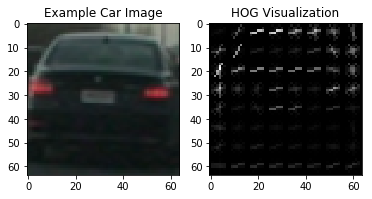

In [9]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Combine and Normalize Features

Now that we've studied several feature extraction methods, we're almost ready to train a classifier, but first, as in any machine learning application, we need to normalize our data. Python's sklearn package provides us with the StandardScaler() method to accomplish this task. 
To apply StandardScaler() we need to first have our data in the right format, as a numpy array where each row is a single feature vector. 
Our goal is to write a function that takes in a list of image filenames, reads them one by one, then applies a color conversion (if necessary) and uses bin_spatial() and color_hist() to generate feature vectors. 

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(image, 'RGB', size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range, chist_flag=False)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

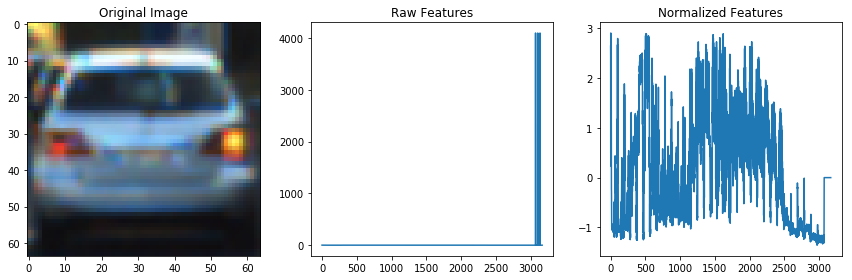

In [11]:
cars = []
notcars = []
for image in car_images:
        cars.append(image)
for image in noncar_images:
        notcars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

# Color histogram SVM Classifier

Now we'll try training a classifier on our dataset. First, we'll see how well it does just using spatially binned color and color histograms.
To do this, we'll use the functions you defined in previous exercises, namely, bin_spatial(), color_hist(), and extract_features(). We'll then read in our car and non-car images, extract the color features for each, and scale the feature vectors to zero mean and unit variance.
All that remains is to define a labels vector, shuffle and split the data into training and testing sets, and finally, define a classifier and train it!

In [12]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

#Now, you're ready to define and train a classifier! Here we'll try a Linear Support Vector Machine. 
#To define and train your classifier it takes just a few lines of code:

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
#Train the SVC
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'seconds to train SVC.')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

38.9 seconds to train SVC.
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3168


In [13]:
#Then you can check the accuracy of your classifier on the test dataset like this:
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
t = time.time()
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy of SVC =  0.910191441441
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  1.  0.  0.]
For labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]

0.0014 seconds to predict 10 labels with SVC.
